In [30]:
import pickle
from  test_city import calculate
from multiprocessing import Pool
import contextily as ctx
import networkx as nx
import osmnx as ox


In [50]:
def get_graph(city_id: str = 'R2555133') -> nx.Graph:
    gdf = ox.geocode_to_gdf(city_id, by_osmid=True)
    polygon_boundary = gdf.unary_union
    graph = ox.graph_from_polygon(polygon_boundary,
                                  network_type='drive',
                                  simplify=True)
    G = nx.Graph(graph)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in G.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in G.edges(data=True):
        H.add_edge(u, v, length=d['length'])
    print(H)
    del city_id, gdf, polygon_boundary, graph, G

get_graph('R8332101')
get_graph('R1250117')

Graph with 746 nodes and 866 edges
Graph with 2098 nodes and 2544 edges


In [35]:
# city_id: R13470549, Graph with 729 nodes and 1068 edges
# city_id: R4676636, Graph with 3349 nodes and 4519 edges
# city_id: R6564910, Graph with 5485 nodes and 7656 edges
# city_id: R71525, Graph with 9517 nodes and 14837 edges
# city_id: R435514, Graph with 21681 nodes and 30128 edges
# city_id: R2555133, Graph with 17793 nodes and 26845 edges
# city_id: R17140517, Graph with 23897 nodes and 35606 edges
# city_id: R62422, Graph with 28088 nodes and 42098 edges
# city_id: R41485, Graph with 43510 nodes and 60563 edges
# city_id: R207359, Graph with 49514 nodes and 72143 edges

In [17]:
total = 6
points_number = 5000

print('THREADS:', total)
print('POINTS:', points_number)

cities = {
    'Durham': 'R8332101',
    'Kamëz': 'R1250117',
    # 'EKB': 'R1250117',
    # 'BARCELONA': 'R347950',
    'Paris': 'R71525',
    'Prague': 'R435514',
    # 'MSK': 'R2555133',
    # 'SBP': 'R337422',
    # 'SINGAPORE': 'R17140517',
    # 'BERLIN': 'R62422',
    # 'ROME': 'R41485',
    # 'LA': 'R207359',
    # 'DUBAI': 'R4479752',
    # 'RIO': 'R2697338',
    # 'DELHI': 'R1942586',
    # 'KAIR': 'R5466227'
}
total_len = len(cities)
l = list(cities.items())
data = [[l[i: total_len: total],points_number, i + 1, total] for i in range(total)]
# print(data)
with Pool(total) as p:
    p.map(calculate, data)

THREADS: 6
POINTS: 5000


Scatter plot saved to data/img\scatter_speed_up_vs_alpha_ASHA.png


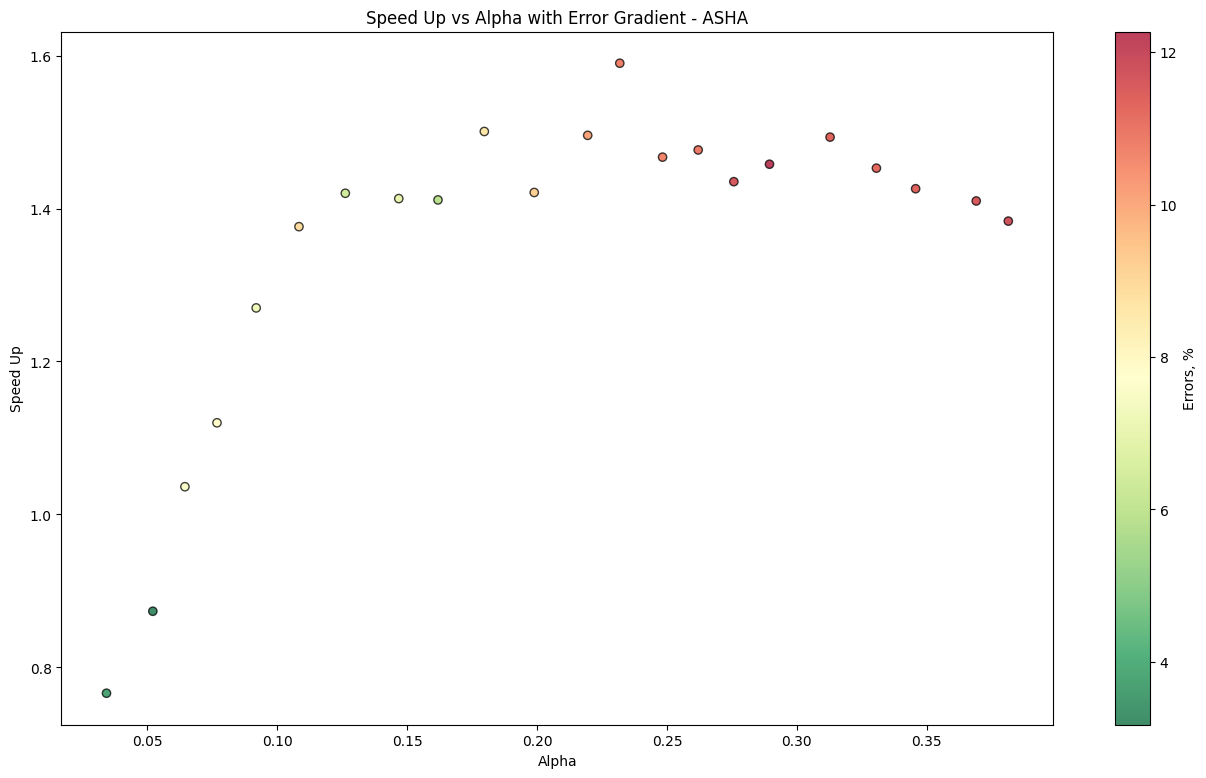

Scatter plot saved to data/img\scatter_speed_up_vs_alpha_KRG.png


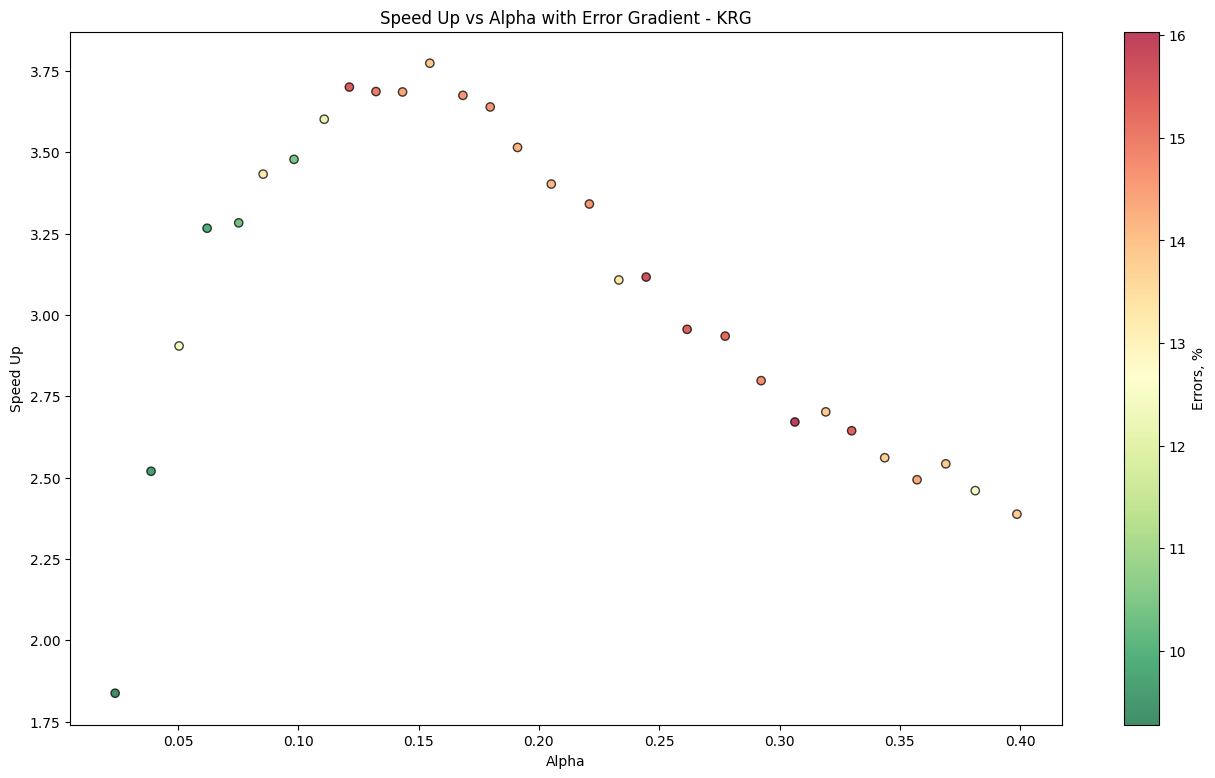

Scatter plot saved to data/img\scatter_speed_up_vs_alpha_PARIS.png


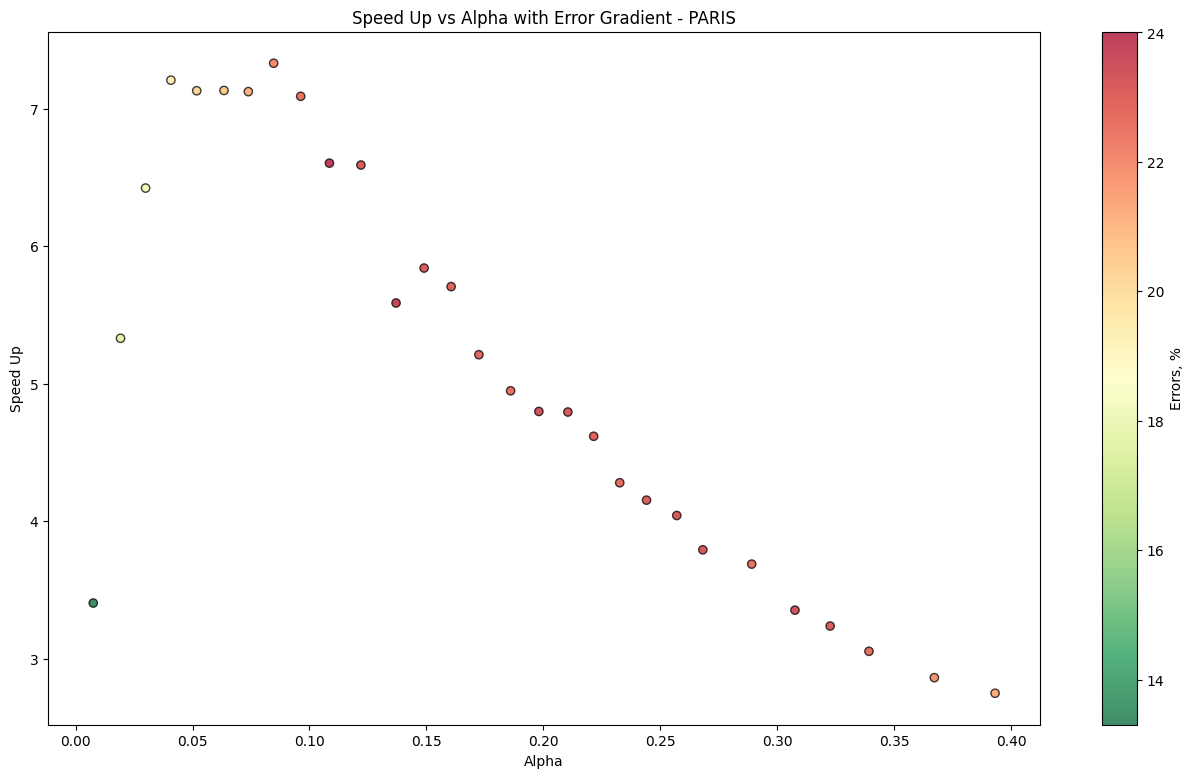

Scatter plot saved to data/img\scatter_speed_up_vs_alpha_Prague.png


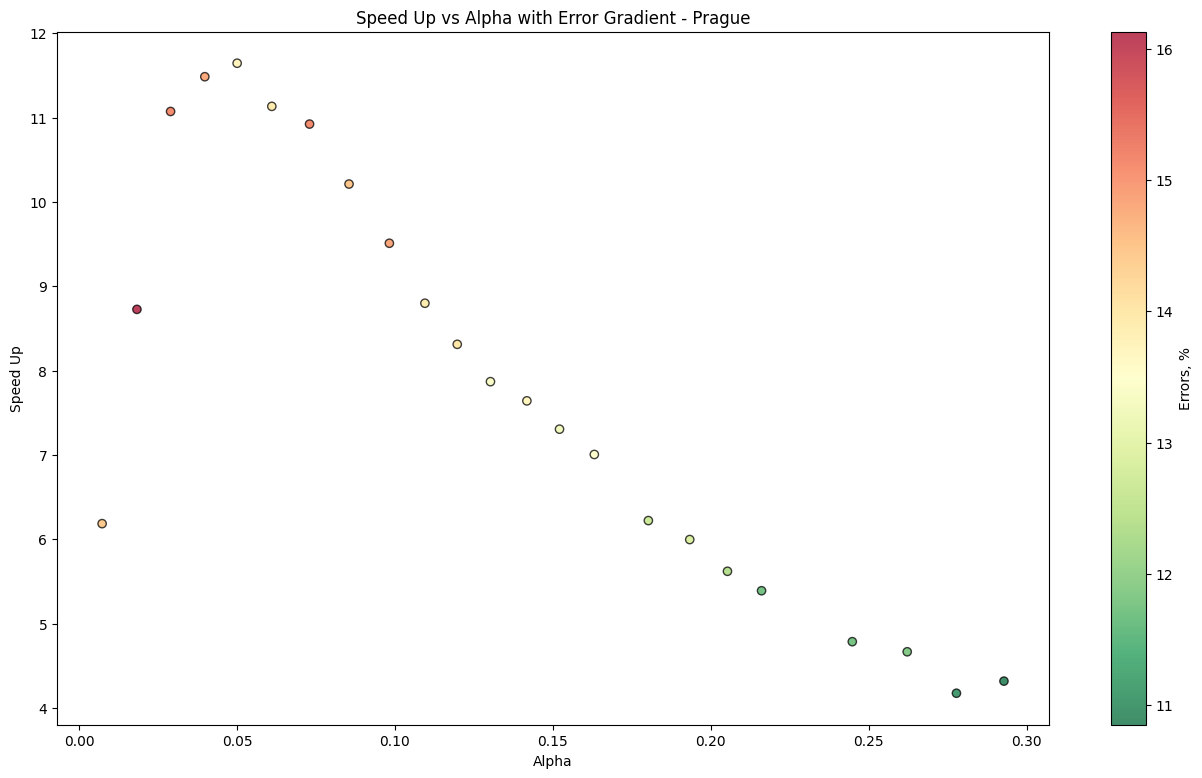

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os

def scatter_visualisation(speed_up, alphas, errors, name='city', output_dir="data/img", show=False):
    plt.figure(figsize=(16, 9))
    
    # Создаем scatter plot
    scatter = plt.scatter(alphas, speed_up, c=errors, cmap='RdYlGn_r', edgecolor='k', alpha=0.75)
    plt.colorbar(scatter, label='Errors, %')
    
    # Устанавливаем подписи для осей
    plt.ylabel('Speed Up')
    plt.xlabel('Alpha')
    plt.title(f'Speed Up vs Alpha with Error Gradient - {name}')
    
    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, f"scatter_speed_up_vs_alpha_{name}.png")
    plt.savefig(file_path, dpi=600)
    
    print(f"Scatter plot saved to {file_path}")
    if show:
        plt.show()
for n in ['Durham', 'Kamëz', 'Paris', 'Prague']:
    with open(f'clusters_results/2024_06_28/{n}.pkl', 'rb') as f:
        data = pickle.load(f)
        # Извлекаем значения speed_up, alpha и errors в отдельные списки
    speed_up = [results.speed_up[0] for results in data.points_results]
    alphas = [results.alpha for results in data.points_results]
    errors = [np.mean(results.errors) * 100 for results in data.points_results]  # усредняем ошибки и масштабируем

    # Вызываем функцию для создания и сохранения scatter plot
    scatter_visualisation(speed_up, alphas, errors, data.name, show=True)

In [ ]:
import matplotlib.pyplot as plt
import os
import pickle

def box_visualisation(absolute_errors, alphas, pfa_times, name='city', output_dir="data/img", show=False):
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Параметры для boxplot
    boxprops = {"color": "black", "linewidth": 3}
    medianprops = {"color": "r", "linewidth": 4}
    whiskerprops = {"color": "black", "linewidth": 3}
    capprops = {"color": "black", "linewidth": 3}

    # Создаем boxplot на основной оси
    ax1.boxplot(absolute_errors, showfliers=False, vert=True, patch_artist=True,
                medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
    ax1.set_ylabel('Errors, %', color='b')
    ax1.set_xlabel('Alpha')
    ax1.set_title(f'Boxplot of Errors - {name}')
    ax1.set_xticks(range(1, len(alphas) + 1))
    ax1.set_xticklabels(alphas)
    ax1.set_ylim(0, 100)  # Установка основной вертикальной оси от 0 до 100

    # Наклон текста на оси x
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Создаем второстепенную ось для pfa time
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(alphas) + 1), pfa_times, color='r', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Speed Up', color='r')

    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, f"boxplot_errors_{name}.png")
    plt.savefig(file_path, dpi=200)
    
    print(f"Boxplot saved to {file_path}")
    if show:
        plt.show()


for n in ['Durham', 'Kamëz', 'Paris', 'Prague']:
    with open(f'clusters_results/2024_06_28/{n}.pkl', 'rb') as f:
        data = pickle.load(f)

        # Извлекаем значения absolute_err, alpha и pfa time в отдельные списки
        absolute_errors = [[i * 100 for i in results.errors] for results in data.points_results]
        alphas = [round(i.alpha, 3) for i in data.points_results]
        speed_up = [i.speed_up[0] for i in data.points_results]

        # Вызываем функцию для создания и сохранения boxplot
        box_visualisation(absolute_errors, alphas, speed_up, data.name, show=True)

Boxplot saved to data/img\boxplot_errors_combined.png


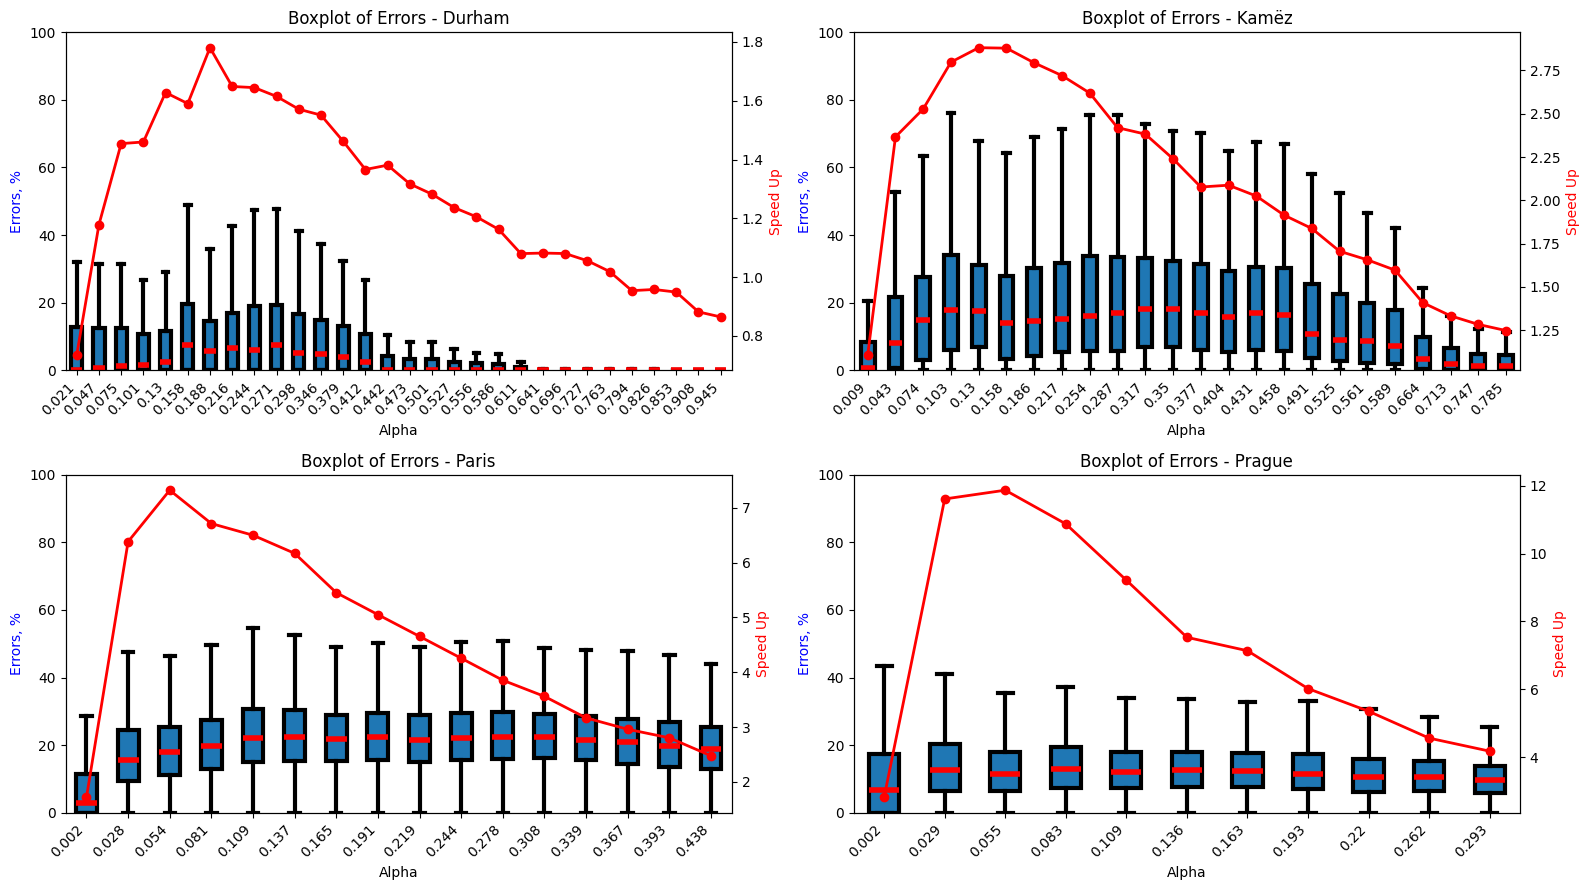

In [21]:
def box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, output_dir="data/img", show=False):
    # Создаем 2x2 подграфики
    fig, axs = plt.subplots(2, 2, figsize=(16, 9))
    axs = axs.flatten()  # Выравниваем массив подграфиков

    # Параметры для boxplot
    boxprops = {"color": "black", "linewidth": 3}
    medianprops = {"color": "r", "linewidth": 4}
    whiskerprops = {"color": "black", "linewidth": 3}
    capprops = {"color": "black", "linewidth": 3}

    for i, ax in enumerate(axs):
        # Создаем boxplot на каждом подграфике
        ax.boxplot(absolute_errors_list[i], showfliers=False, vert=True, patch_artist=True,
                   medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.set_ylabel('Errors, %', color='b')
        ax.set_xlabel('Alpha')
        ax.set_title(f'Boxplot of Errors - {names[i]}')
        ax.set_xticks(range(1, len(alphas_list[i]) + 1))
        ax.set_xticklabels(alphas_list[i])
        ax.set_ylim(0, 100)  # Установка основной вертикальной оси от 0 до 100

        # Наклон текста на оси x
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Создаем второстепенную ось для pfa time
        ax2 = ax.twinx()
        ax2.plot(range(1, len(alphas_list[i]) + 1), pfa_times_list[i], color='r', marker='o', linestyle='-', linewidth=2)
        ax2.set_ylabel('Speed Up', color='r')

    # Настройка пространства между подграфиками
    plt.tight_layout()

    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, "boxplot_errors_combined.png")
    plt.savefig(file_path, dpi=200)
    
    print(f"Boxplot saved to {file_path}")
    if show:
        plt.show()

# Списки для хранения данных
absolute_errors_list = []
alphas_list = []
pfa_times_list = []
names = ['Durham', 'Kamëz', 'Paris', 'Prague']

for n in names:
    with open(f'clusters_results/2024_06_28/{n}.pkl', 'rb') as f:
        data = pickle.load(f)

        # Извлекаем значения absolute_err, alpha и pfa time в отдельные списки
        absolute_errors = [[i * 100 for i in results.errors] for results in data.points_results]
        alphas = [round(i.alpha, 3) for i in data.points_results]
        speed_up = [i.speed_up[0] for i in data.points_results]

        # Добавляем данные в списки
        absolute_errors_list.append(absolute_errors)
        alphas_list.append(alphas)
        pfa_times_list.append(speed_up)

# Вызываем функцию для создания и сохранения boxplot
box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, show=True)

In [61]:
data.points_results[0].

#  'absolute_err'
#  'absolute_time'
#  'alpha'
#  'centroid_density'
#  'centroid_edges'
#  'centroid_nodes'
#  'errors'
#  'resolution'
#  'speed_up'
#  'time'

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'absolute_err',
 'absolute_time',
 'alpha',
 'centroid_density',
 'centroid_edges',
 'centroid_nodes',
 'errors',
 'resolution',
 'speed_up',
 'time']

In [2]:
import pickle
import pandas as pd
import numpy as np
for n in ['ASHA']:
    with open(f'clusters_results/2024_06_26/{n}.pkl', 'rb') as f:
        data = pickle.load(f)
    absolute_errors = [np.array([i * 100 for i in results.errors]).mean() for results in data.points_results]
    alphas = [round(i.alpha, 3) for i in data.points_results]
    pfa_times = [i.speed_up[0] for i in data.points_results]
df = pd.DataFrame([absolute_errors, alphas, pfa_times]).T
df.columns = ['error', 'alpha', 'speed_up']
df

,error,alpha,speed_up
0,3.771089,0.034,0.766220
1,3.173707,0.052,0.873412
2,7.558484,0.064,1.036243
3,7.840938,0.077,1.119833
4,7.257565,0.092,1.270069
5,8.921978,0.108,1.376309
6,6.386283,0.126,1.419966
7,6.953296,0.147,1.413017
8,5.879155,0.162,1.411289
9,8.615446,0.180,1.500780


In [4]:
import requests
import json
import pandas as pd
from tqdm import tqdm

def get_cities_with_population_greater_than_n(n):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
        [out:json];
        (
            relation["place"="city"];
            relation["place"="town"];
            relation["place"="village"];
        );
        out;
    """
    response = requests.get(overpass_url, params={"data": overpass_query})
    data = response.json()

    result = {
        'cities': [],
        'city_ids': [],
        'population_list': [],
        'place': []
    }

    for element in tqdm(data["elements"], leave=False):
        if "population" in element["tags"]:
            population = element["tags"]["population"].replace(" ", "")
            try:
                population = int(population)
                if population >= n:
                    if "name" in element["tags"]:
                        result['cities'].append(element['tags']['name'])  # Добавляем название города в список городов
                        result['city_ids'].append(element['id'])  # Добавляем идентификатор в список идентификаторов
                        result['population_list'].append(element["tags"]["population"].replace(" ", ""))
                        result['place'].append(element['tags']['place'])
            except ValueError:
                # Здесь можно добавить логирование или другую обработку ошибок
                print(f"Не удалось преобразовать население в число для {element['tags'].get('name', 'неизвестного города')}")
    
    return pd.DataFrame(result)  # Возвращаем оба списка    

if __name__ == "__main__":
    min_population = 30000  # Задайте минимальное население
    result = get_cities_with_population_greater_than_n(min_population)

Не удалось преобразовать население в число для San Bernardino
Не удалось преобразовать население в число для Newport
Не удалось преобразовать население в число для Moncton
Не удалось преобразовать население в число для Riverview
Не удалось преобразовать население в число для בני ברק
Не удалось преобразовать население в число для Barnstable
Не удалось преобразовать население в число для Edmonton
Не удалось преобразовать население в число для Myrtleford
Не удалось преобразовать население в число для Tukboy
Не удалось преобразовать население в число для طنجة
Не удалось преобразовать население в число для Fontana
Не удалось преобразовать население в число для Погорелое Городище
Не удалось преобразовать население в число для Belmopan
Не удалось преобразовать население в число для Ontario
Не удалось преобразовать население в число для Ma Gyi Phyu (မန်ကျည်းဖြူ)
Не удалось преобразовать население в число для Gardi Muladub
Не удалось преобразовать население в число для Benque Viejo del Carmen
Н

In [5]:
import os
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

# Путь к папке с файлами CSV
folder_path = 'data\\csv_1'
files = [f for f in os.listdir(folder_path) if f.startswith('output_R') and f.endswith('.csv')]

# Чтение всех файлов CSV и объединение их в один DataFrame
data_frames = []
for file in files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df['R_number'] = file.split('_R')[1].split('.csv')[0]
    data_frames.append(df)

combined_df = pd.concat(data_frames, ignore_index=True)
combined_df['speed_up'] = combined_df['dijkstra_time'] / combined_df['times']

# Создание словаря для сопоставления city_ids с названием города
city_id_to_name = dict(zip(result['city_ids'], result['cities']))

# Функция для получения центра города по названию города
def get_city_center_by_name(city_name):
    try:
        gdf = ox.geocode_to_gdf(city_name)
        center = gdf.geometry.centroid.iloc[0]
        return gdf, center
    except Exception as e:
        print(f"Failed to get city center for city: {city_name}, error: {e}")
        return None, None

# Получение уникальных значений R_number
unique_r_numbers = combined_df['R_number'].unique()

# Скачивание данных и создание GeoDataFrame
city_data = []
for R_number in tqdm(unique_r_numbers):
    city_name = city_id_to_name.get(int(R_number))
    if city_name:
        place_name, center = get_city_center_by_name(city_name)
        if place_name is not None:
            city_data.append({
                'R_number': R_number,
                'name_city': city_name,
                'geometry': center
            })

city_gdf = gpd.GeoDataFrame(city_data, geometry='geometry', crs='EPSG:4326')

100%|██████████| 756/756 [00:35<00:00, 21.11it/s]


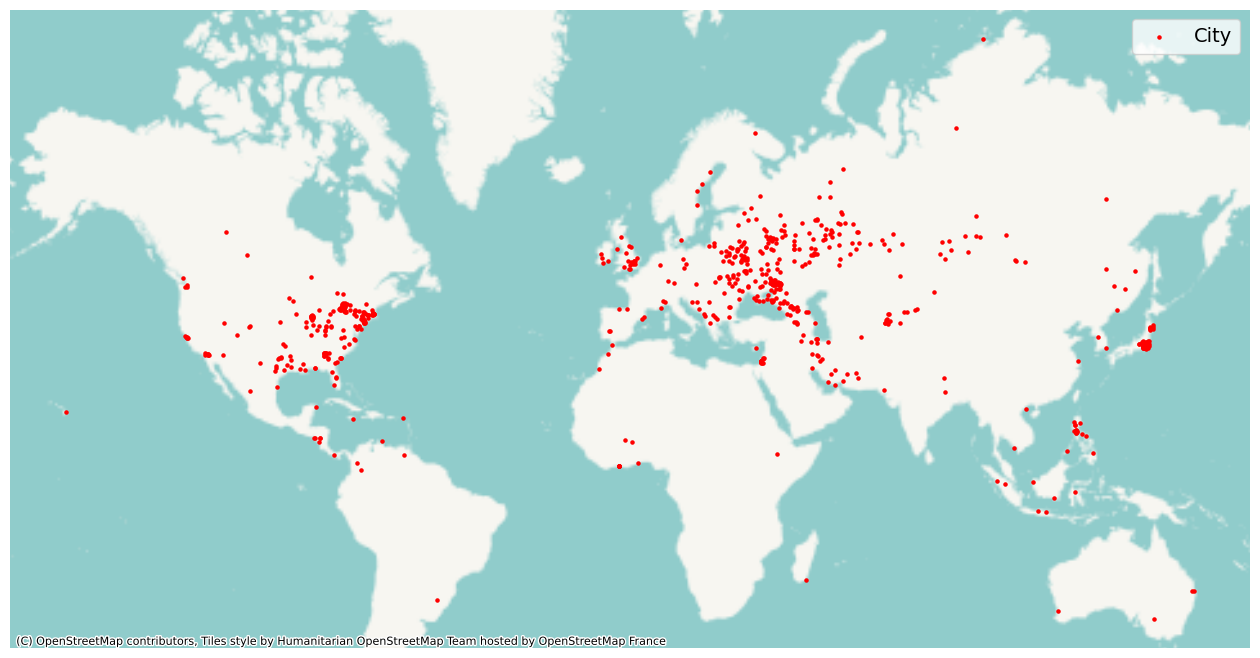

In [89]:
fig, ax = plt.subplots(figsize=(16, 9))
city_gdf = city_gdf.to_crs(epsg=3857)
city_gdf.plot(ax=ax, color='red', markersize=5, label='City')
ctx.add_basemap(ax, zoom=1)
ax.set_axis_off()

# Добавление легенды
ax.legend(loc='upper right', fontsize=14)

plt.savefig('data/img/world_map.png', dpi=200, bbox_inches='tight')
plt.show()

In [41]:
# filtered_df = combined_df[combined_df['error'] <= 10]
# min_time_df = combined_df.loc[combined_df.groupby('R_number')['times'].idxmin()]
max_speed_up_df = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]
final_gdf = max_speed_up_df.merge(city_gdf, on='R_number')
final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry', crs='EPSG:4326')

In [34]:
combined_df

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up
0,2.408896,0.543499,12.003601,0.011,10.506312,10089445,0.875263
1,2.601728,0.457626,11.130596,0.014,10.506312,10089445,0.943913
2,7.551250,0.291848,8.531677,0.022,10.506312,10089445,1.231447
3,5.011558,0.210539,6.337589,0.045,10.506312,10089445,1.657777
4,6.868845,0.206141,5.299418,0.070,10.506312,10089445,1.982541
...,...,...,...,...,...,...,...
6607,11.824568,0.135997,3.626847,0.089,7.436029,9986400,2.050274
6608,13.653888,0.158015,3.295653,0.151,7.436029,9986400,2.256314
6609,12.516316,0.188121,3.310578,0.252,7.436029,9986400,2.246142
6610,12.271537,0.257031,3.896620,0.418,7.436029,9986400,1.908328


In [43]:
final_gdf.to_file('final_gdf.geojson')

In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from tqdm import tqdm

# Функция для загрузки графа из файлов формата graphml
def load_graph(graph_filename):
    return nx.read_graphml(graph_filename)

# Создание словаря для хранения информации о графах
graph_info = {}

# Проход по уникальным значениям R_number в DataFrame
for R_number in tqdm(combined_df['R_number'].unique()):
    # Формируем путь к файлу графа
    graph_filename = f'data/graphs_1/graph_R{R_number}.graphml'
    
    # Загружаем граф из файла
    G = load_graph(graph_filename)
    
    # Собираем информацию о графе
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    sparsity = num_edges / num_nodes if num_nodes > 0 else 0
    
    # Сохраняем информацию в словарь
    graph_info[R_number] = {
        'nodes': num_nodes,
        'edges': num_edges,
        'sparsity': sparsity
    }

# Создание новых колонок в final_gdf и заполнение их значениями из словаря
combined_df['nodes'] = combined_df['R_number'].map(lambda x: graph_info[x]['nodes'])
combined_df['edges'] = combined_df['R_number'].map(lambda x: graph_info[x]['edges'])
combined_df['sparsity'] = combined_df['R_number'].map(lambda x: graph_info[x]['sparsity'])
combined_df['k'] = combined_df['nodes'] / (combined_df['alpha'] * combined_df['nodes'])
combined_df.to_csv('For_Gosha.csv')

NameError: name 'combined_df' is not defined

In [2]:
import pandas as pd
combined_df = pd.read_csv('For_Gosha.csv')

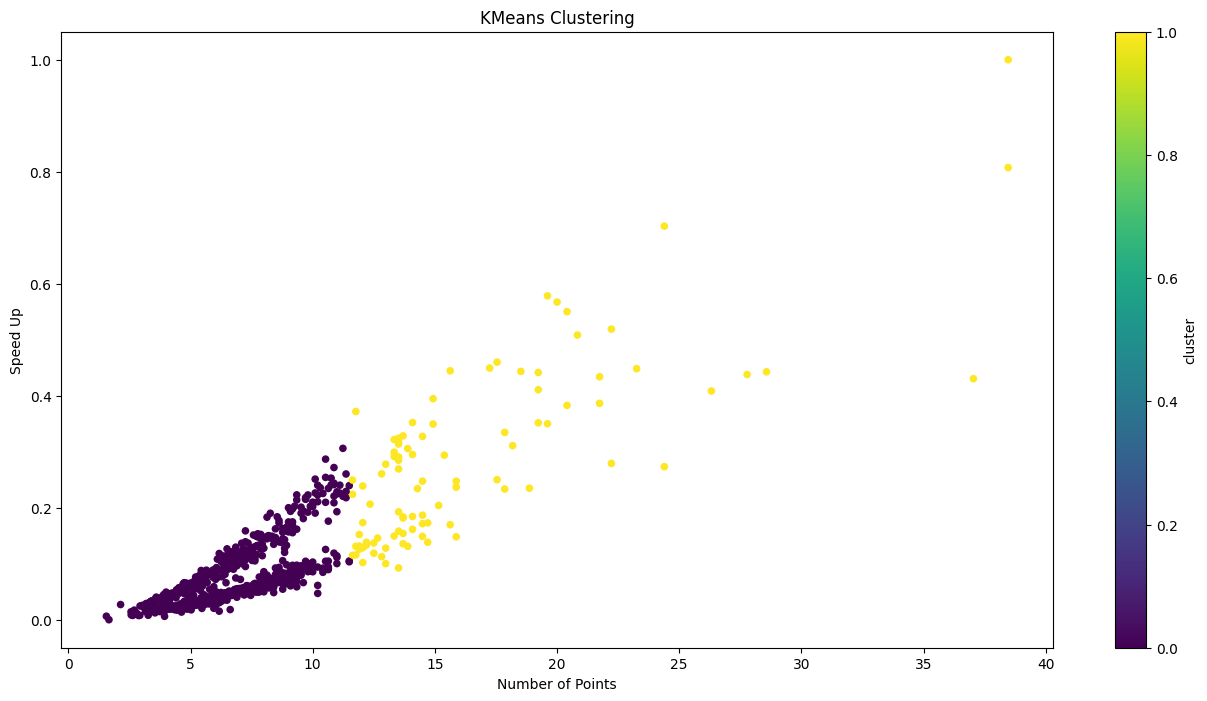

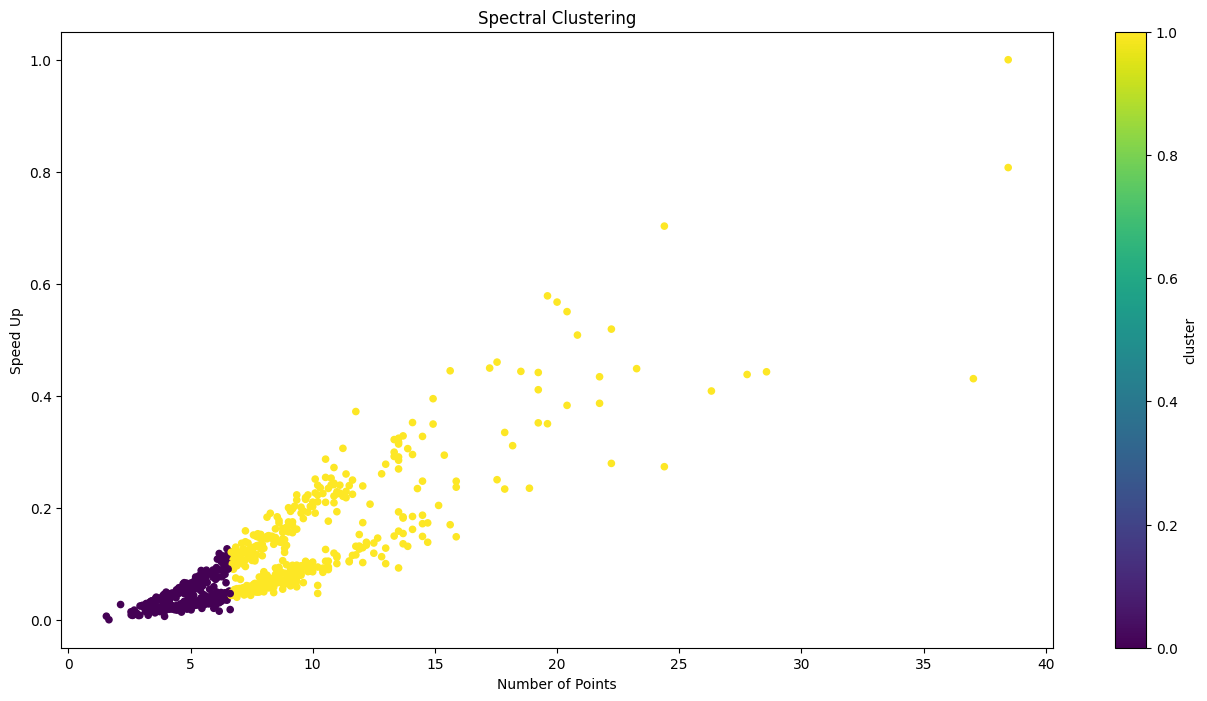

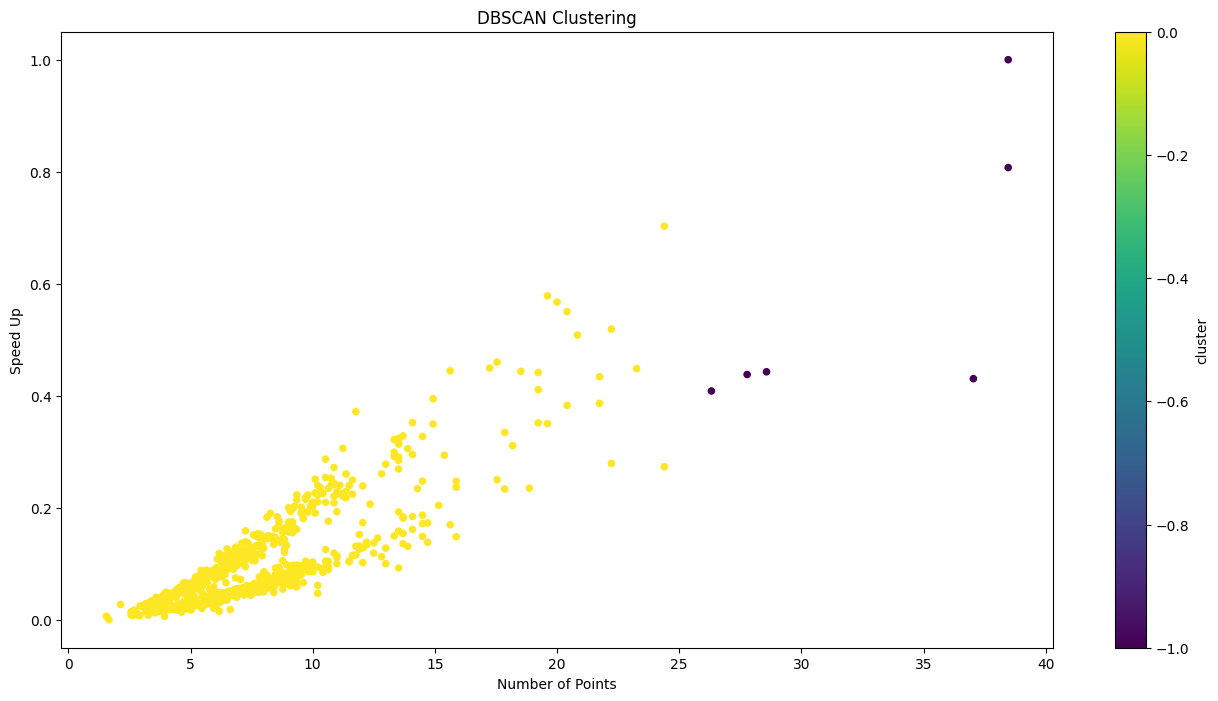

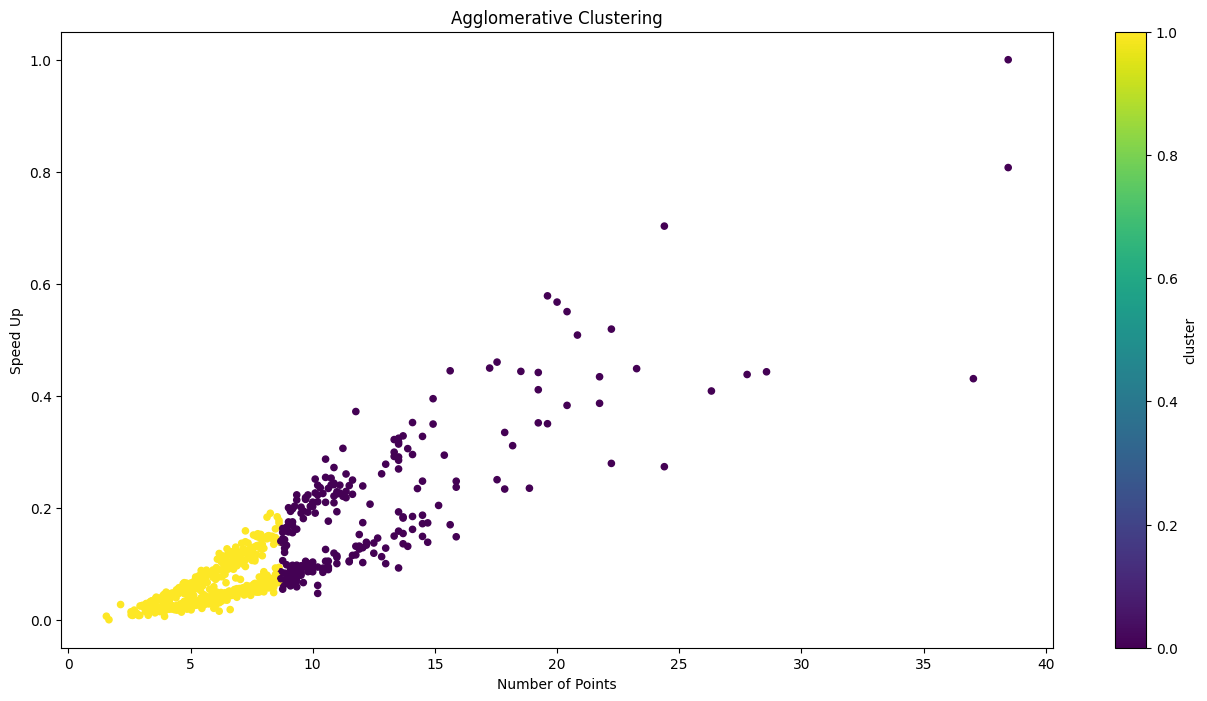

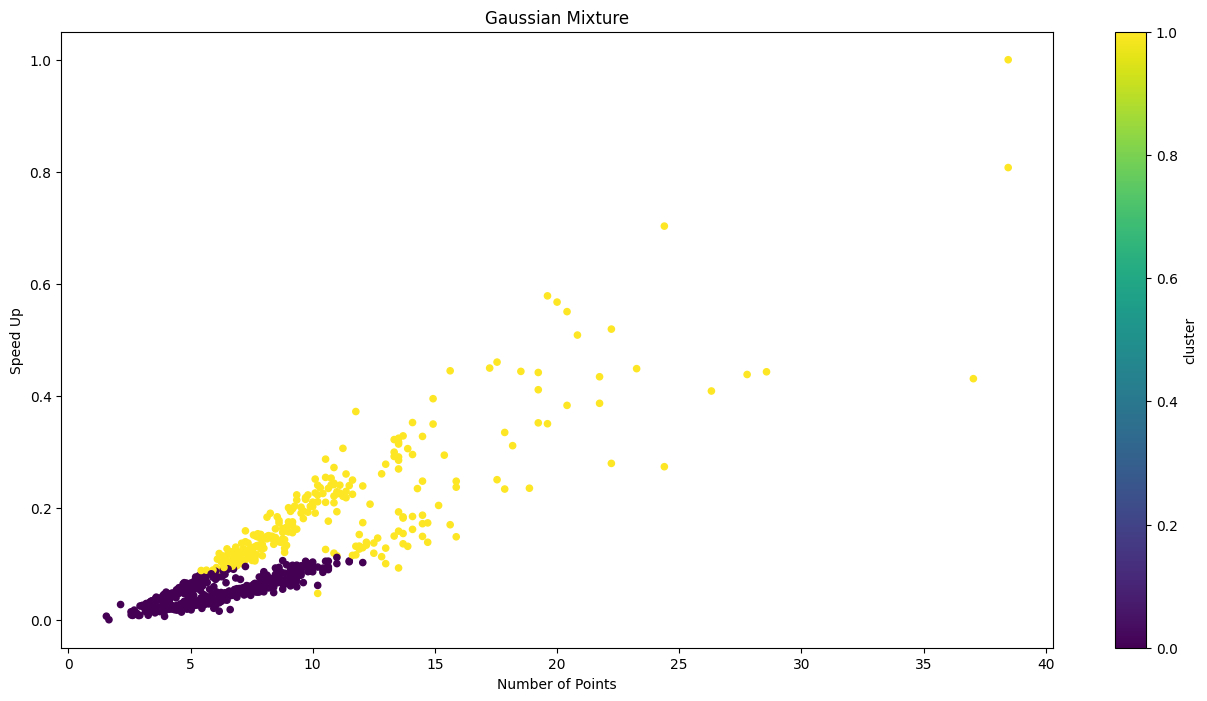

In [84]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
import pandas as pd
import numpy as np

# Выбор строк с максимальным значением speed_up для каждого R_number
test_df = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()].copy()

scaler = MinMaxScaler()
test_df['speed_up'] = scaler.fit_transform(test_df[['speed_up']])

# Список методов кластеризации и их параметры
clustering_methods = {
    # 'KMeans': KMeans(n_clusters=2, random_state=42),
    # 'SpectralClustering': SpectralClustering(n_clusters=2, random_state=42, affinity='nearest_neighbors'),
    # 'DBSCAN': DBSCAN(eps=2, min_samples=5),
    # 'AgglomerativeClustering': AgglomerativeClustering(n_clusters=2),
    # 'GaussianMixture': GaussianMixture(n_components=2),
    ''
}

# Подписи для графиков
plot_titles = {
    'KMeans': 'KMeans Clustering',
    'SpectralClustering': 'Spectral Clustering',
    'DBSCAN': 'DBSCAN Clustering',
    'AgglomerativeClustering': 'Agglomerative Clustering',
    'GaussianMixture': 'Gaussian Mixture'
}

# Построение графиков для каждого метода кластеризации
for method_name, model in clustering_methods.items():
    # Копирование данных для текущего метода
    df = test_df.copy()

    # Применение кластеризации
    df['cluster'] = model.fit_predict(df[['k', 'speed_up']])
    
    # Построение графика
    ax = df.plot(
        figsize=(16, 8), kind='scatter', x='k', y='speed_up', c='cluster', cmap='viridis'
    )
    ax.set_xlabel('Number of Points')
    ax.set_ylabel('Speed Up')
    ax.set_title(plot_titles[method_name])

    # Сохранение изображения
    # plt.savefig(f'data/img/scatter_plot_{method_name}.png', dpi=600, bbox_inches='tight')

    # Отображение графика
    plt.show()

Boxplot saved to data\img\boxplot_errors_combined.png


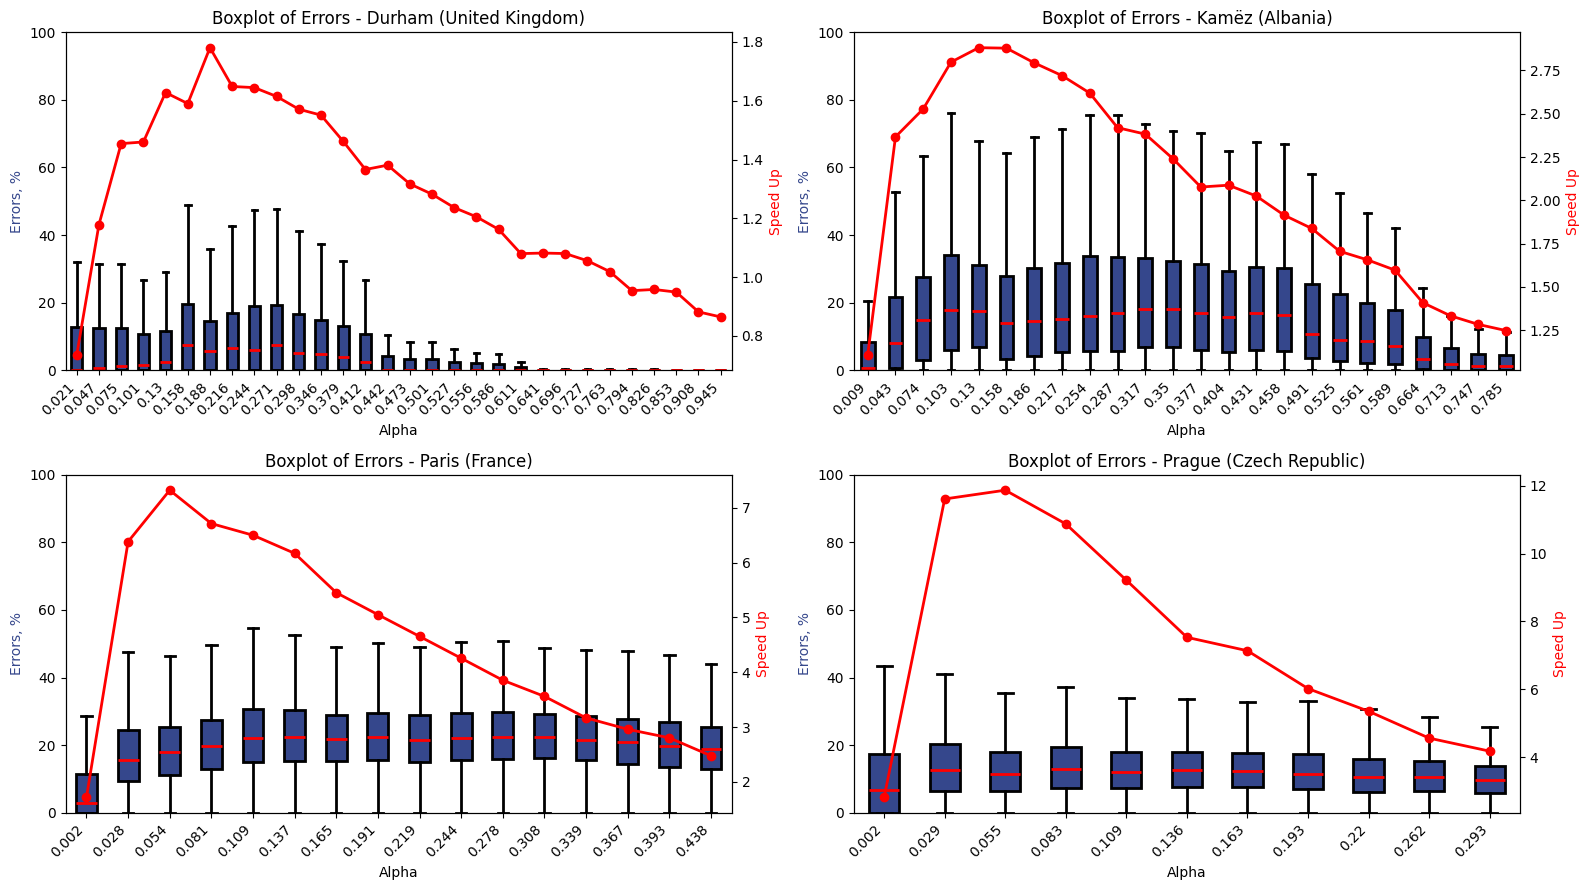

In [110]:
import os
import pickle
import matplotlib.pyplot as plt

def box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, output_dir="data\\img", show=False):
    # Создаем 2x2 подграфики
    fig, axs = plt.subplots(2, 2, figsize=(16, 9))
    axs = axs.flatten()  # Выравниваем массив подграфиков

    country = {
        'Durham':  'United Kingdom',
        'Kamëz':  'Albania',
        'Paris':  'France',
        'Prague':  'Czech Republic'
    }

    # Параметры для boxplot
    boxprops = {"color": "black", "linewidth": 2, "facecolor": "#35478C"}
    medianprops = {"color": "r", "linewidth": 2}
    whiskerprops = {"color": "black", "linewidth": 2}
    capprops = {"color": "black", "linewidth": 2}

    for i, ax in enumerate(axs):
        # Создаем boxplot на каждом подграфике
        ax.boxplot(absolute_errors_list[i], showfliers=False, vert=True, patch_artist=True,
                   medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.set_ylabel('Errors, %', color='#35478C', fontweight=500)
        ax.set_xlabel('Alpha')
        ax.set_title(f'Boxplot of Errors - {names[i]} ({country[names[i]]})')
        ax.set_xticks(range(1, len(alphas_list[i]) + 1))
        ax.set_xticklabels(alphas_list[i])
        ax.set_ylim(0, 100)  # Установка основной вертикальной оси от 0 до 100

        # Наклон текста на оси x
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Создаем второстепенную ось для pfa time
        ax2 = ax.twinx()
        ax2.plot(range(1, len(alphas_list[i]) + 1), pfa_times_list[i], color='r', marker='o', linestyle='-', linewidth=2)
        ax2.set_ylabel('Speed Up', color='r', fontweight=500)

    # Настройка пространства между подграфиками
    plt.tight_layout()

    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, "boxplot_errors_combined.png")
    plt.savefig(file_path, dpi=200, bbox_inches='tight')
    
    print(f"Boxplot saved to {file_path}")
    if show:
        plt.show()

# Списки для хранения данных
absolute_errors_list = []
alphas_list = []
pfa_times_list = []
names = ['Durham', 'Kamëz', 'Paris', 'Prague']

for n in names:
    with open(f'clusters_results\\2024_06_28\\{n}.pkl', 'rb') as f:
        data = pickle.load(f)

        # Извлекаем значения absolute_err, alpha и pfa time в отдельные списки
        absolute_errors = [[i * 100 for i in results.errors] for results in data.points_results]
        alphas = [round(i.alpha, 3) for i in data.points_results]
        speed_up = [i.speed_up[0] for i in data.points_results]

        # Добавляем данные в списки
        absolute_errors_list.append(absolute_errors)
        alphas_list.append(alphas)
        pfa_times_list.append(speed_up)

# Вызываем функцию для создания и сохранения boxplot
box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, show=True)

In [29]:
combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]

,Unnamed: 0,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,nodes,edges,sparsity,k
5546,5546,11.811286,0.853824,5.722600,0.086,27.092109,62145,4.734231,3311,4639,1.401087,11.627907
5555,5555,14.019506,2.344734,8.165886,0.123,48.718334,62407,5.966081,4821,6826,1.415889,8.130081
5562,5562,12.705562,43.421238,30.855611,0.048,587.061125,62422,19.026073,28088,42098,1.498790,20.833333
5572,5572,14.393217,0.483166,4.615371,0.118,16.113550,62430,3.491279,2119,2864,1.351581,8.474576
5581,5581,14.419885,4.685738,10.497882,0.108,83.166768,62644,7.922243,7028,9564,1.360842,9.259259
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,11.085877,0.213889,3.785029,0.132,9.493293,17640743,2.508117,1625,1800,1.107692,7.575758
2196,2196,13.089229,0.756119,5.505742,0.169,18.255815,17640744,3.315777,2728,3087,1.131598,5.917160
2206,2206,13.765325,0.209772,3.611989,0.204,7.291389,17642563,2.018663,1291,1679,1.300542,4.901961
2214,2214,9.887748,1.025475,7.366937,0.096,28.773922,17642564,3.905819,3981,4724,1.186637,10.416667


AttributeError: PathCollection.set() got an unexpected keyword argument 'hue'

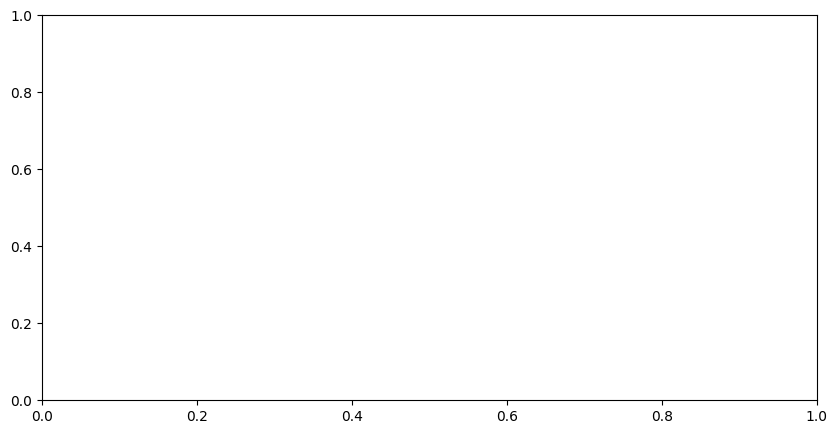

In [30]:
combined_df.drop('Unnamed: 0', axis=1).loc[combined_df.groupby('R_number')['speed_up'].idxmax()].plot(
    figsize=(10, 5), 
    kind='scatter', 
    x='k', 
    y='speed_up',
    color='#4E7AC7',
    hue='nodes',  # группировка по колонке 'nodes'
    palette='tab10',  # цветовая палитра
    edgecolor='black', 
    alpha=0.95,  
    fontsize=16
)

combined_df.drop('Unnamed: 0', axis=1).loc[combined_df.groupby('R_number')['speed_up'].idxmax()][combined_df['nodes'].between(0, 1000000)].plot(
    figsize=(10, 5), 
    kind='scatter', 
    x='k', 
    y='speed_up',
    color='#4E7AC7', 
    edgecolor='black', 
    alpha=0.95,  
    fontsize=16
)

In [41]:
max_speed_up_df.sort_values('node_group')

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,nodes,edges,sparsity,k,node_group
1595,16.034130,0.035252,0.231442,0.252,0.309744,1653741,1.338323,341,466,1.366569,3.968254,"(107.999, 603.0]"
1278,14.673193,0.038868,0.457948,0.224,0.621461,1420221,1.357055,465,564,1.212903,4.464286,"(107.999, 603.0]"
1158,15.888378,0.044279,0.233899,0.253,0.307043,1382923,1.312712,415,577,1.390361,3.952569,"(107.999, 603.0]"
4719,14.119584,0.020718,0.028547,0.317,0.031092,3406249,1.089164,208,302,1.451923,3.154574,"(107.999, 603.0]"
6096,30.163324,0.059968,0.610326,0.239,0.816675,7727439,1.338096,490,716,1.461224,4.184100,"(107.999, 603.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
3724,15.043591,5.231616,12.188785,0.086,106.012819,2682892,8.697571,8270,12344,1.492624,11.627907,"(8028.5, 90645.0]"
2476,15.572736,5.327830,13.915841,0.095,113.774641,183453,8.175909,8112,10978,1.353304,10.526316,"(8028.5, 90645.0]"
3716,14.901547,18.222413,16.871809,0.067,223.606180,2682891,13.253243,14454,21186,1.465753,14.925373,"(8028.5, 90645.0]"
2656,14.394394,86.941710,33.180521,0.043,559.006285,188022,16.847423,24953,41092,1.646776,23.255814,"(8028.5, 90645.0]"


In [57]:
max_speed_up_df.sort_values('node_group')

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,nodes,edges,sparsity,k,node_group
5546,11.811286,0.853824,5.722600,0.086,27.092109,62145,4.734231,3311,4639,1.401087,11.627907,"(2899.0, 3322.5]"
5555,14.019506,2.344734,8.165886,0.123,48.718334,62407,5.966081,4821,6826,1.415889,8.130081,"(4086.5, 4821.0]"
5562,12.705562,43.421238,30.855611,0.048,587.061125,62422,19.026073,28088,42098,1.498790,20.833333,"(12361.5, 90645.0]"
5572,14.393217,0.483166,4.615371,0.118,16.113550,62430,3.491279,2119,2864,1.351581,8.474576,"(1877.5, 2139.25]"
5581,14.419885,4.685738,10.497882,0.108,83.166768,62644,7.922243,7028,9564,1.360842,9.259259,"(6043.5, 8028.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,11.085877,0.213889,3.785029,0.132,9.493293,17640743,2.508117,1625,1800,1.107692,7.575758,"(1477.0, 1646.0]"
2196,13.089229,0.756119,5.505742,0.169,18.255815,17640744,3.315777,2728,3087,1.131598,5.917160,"(2460.0, 2899.0]"
2206,13.765325,0.209772,3.611989,0.204,7.291389,17642563,2.018663,1291,1679,1.300542,4.901961,"(1126.5, 1328.25]"
2214,9.887748,1.025475,7.366937,0.096,28.773922,17642564,3.905819,3981,4724,1.186637,10.416667,"(3322.5, 4086.5]"


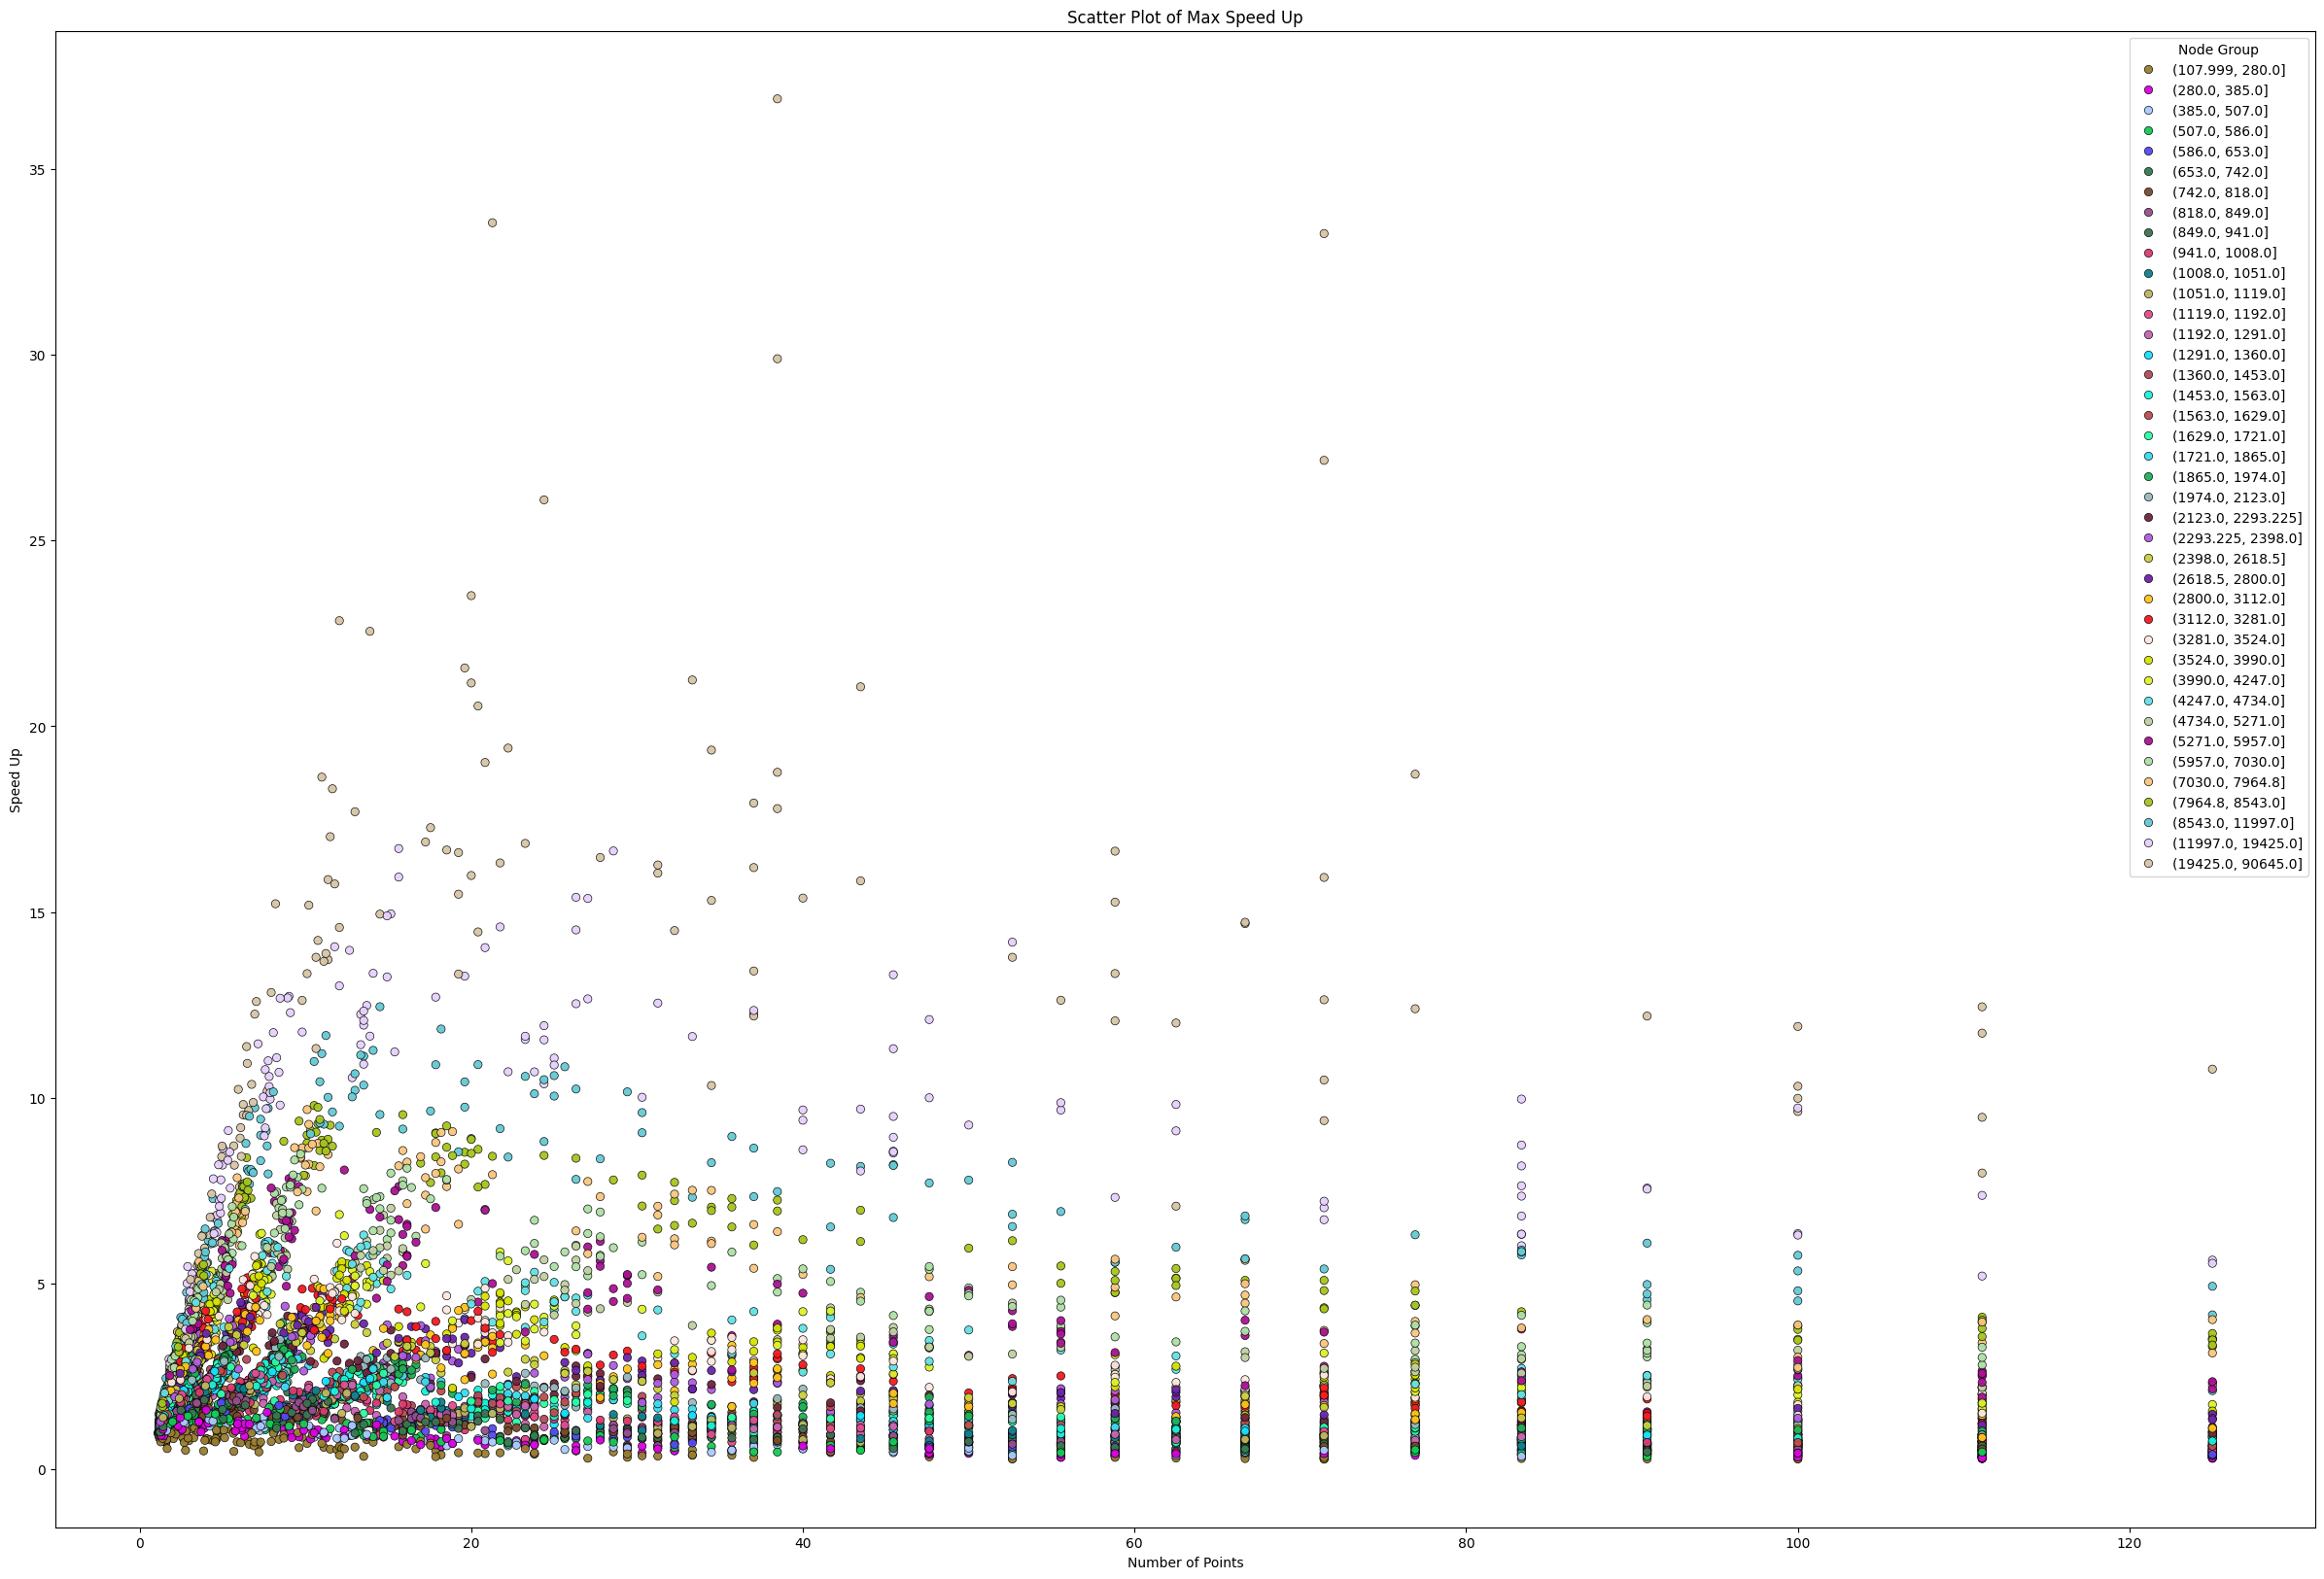

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_hex_colors(n):
    colors = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(color)
    return colors

# Удаляем ненужную колонку
df = combined_df.drop('Unnamed: 0', axis=1)

# Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
max_speed_up_df = df#.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]

# Создаем группы на основе квартилей 'nodes'
q = 40
colors = generate_hex_colors(q)
max_speed_up_df['node_group'] = pd.qcut(max_speed_up_df['nodes'], q=q, labels=[i for i in range(q)])
max_speed_up_df['node_group_gap'] = pd.qcut(max_speed_up_df['nodes'], q=q)

# Построение графика с разбиением по группам 'node_group'
plt.figure(figsize=(30, 20))
sns.scatterplot(
    data=max_speed_up_df,
    x='k',
    y='speed_up',
    hue='node_group_gap',  # группировка по новой колонке 'node_group'
    palette=colors,  # цветовая палитра
    edgecolor='black',
    alpha=0.95
)

plt.title('Scatter Plot of Max Speed Up')
plt.xlabel('Number of Points')
plt.ylabel('Speed Up')
plt.legend(title='Node Group')
plt.show()


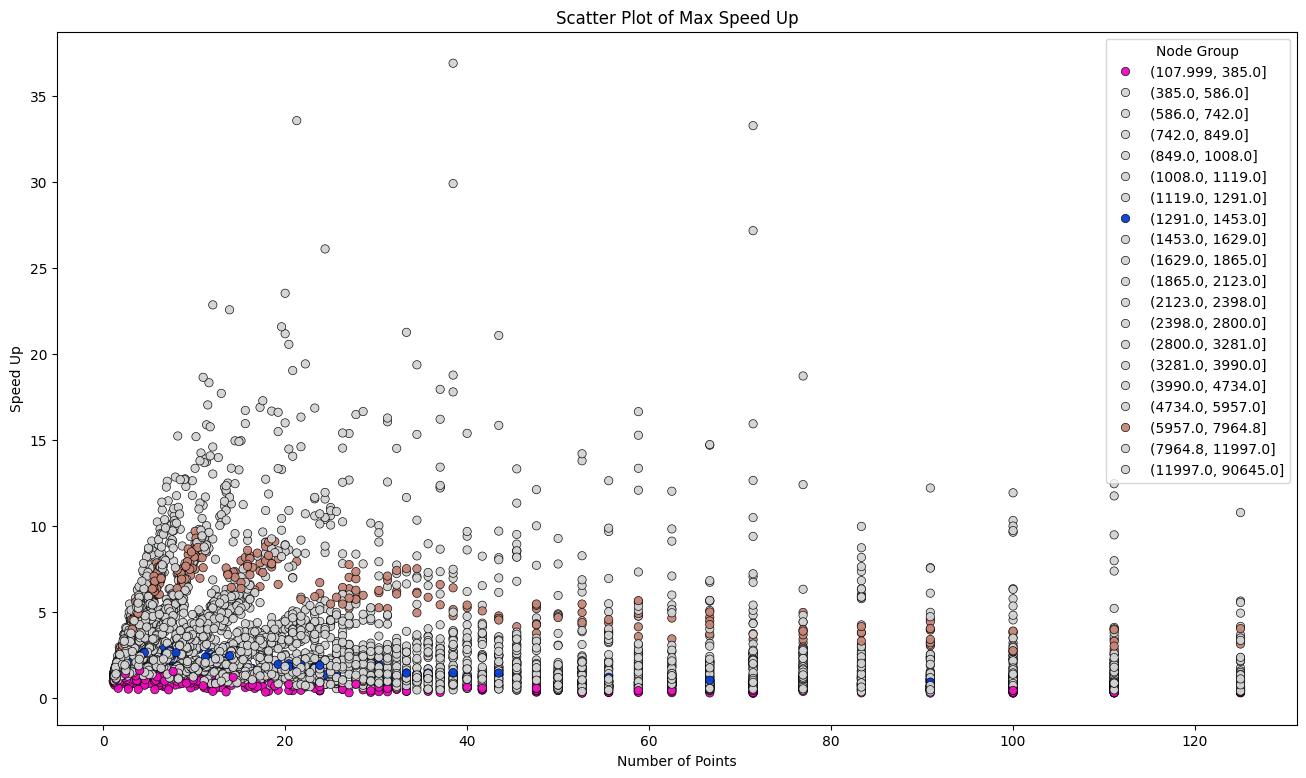

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_hex_colors(n):
    colors = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(color)
    return colors

# Удаляем ненужную колонку
df = combined_df.drop('Unnamed: 0', axis=1)

# Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
max_speed_up_df = df#.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]

# Создаем группы на основе квартилей 'nodes'
q = 20
colors = generate_hex_colors(q)
max_speed_up_df['node_group'] = pd.qcut(max_speed_up_df['nodes'], q=q, labels=[i for i in range(q)])
max_speed_up_df['node_group_gap'] = pd.qcut(max_speed_up_df['nodes'], q=q)

# Массив классов, которые нужно выделить
selected_classes = [0, 7, 17]  # Пример массива

# Генерация цветовой палитры, включая серый для невыбранных классов
palette = {group: (colors[i] if i in selected_classes else '#D3D3D3') for i, group in enumerate(max_speed_up_df['node_group_gap'].cat.categories)}

# Построение графика с разбиением по группам 'node_group'
plt.figure(figsize=(16, 9))
sns.scatterplot(
    data=max_speed_up_df,
    x='k',
    y='speed_up',
    hue='node_group_gap',  # группировка по новой колонке 'node_group'
    palette=palette,  # цветовая палитра
    edgecolor='black',
    alpha=0.95
)

plt.title('Scatter Plot of Max Speed Up')
plt.xlabel('Number of Points')
plt.ylabel('Speed Up')
plt.legend(title='Node Group')
plt.show()


In [65]:
max_speed_up_df

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,nodes,edges,sparsity,k,node_group
5546,11.811286,0.853824,5.722600,0.086,27.092109,62145,4.734231,3311,4639,1.401087,11.627907,"[3300, 3600)"
5555,14.019506,2.344734,8.165886,0.123,48.718334,62407,5.966081,4821,6826,1.415889,8.130081,"[4800, 5100)"
5562,12.705562,43.421238,30.855611,0.048,587.061125,62422,19.026073,28088,42098,1.498790,20.833333,"[27900, 28200)"
5572,14.393217,0.483166,4.615371,0.118,16.113550,62430,3.491279,2119,2864,1.351581,8.474576,"[2100, 2400)"
5581,14.419885,4.685738,10.497882,0.108,83.166768,62644,7.922243,7028,9564,1.360842,9.259259,"[6900, 7200)"
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,11.085877,0.213889,3.785029,0.132,9.493293,17640743,2.508117,1625,1800,1.107692,7.575758,"[1500, 1800)"
2196,13.089229,0.756119,5.505742,0.169,18.255815,17640744,3.315777,2728,3087,1.131598,5.917160,"[2700, 3000)"
2206,13.765325,0.209772,3.611989,0.204,7.291389,17642563,2.018663,1291,1679,1.300542,4.901961,"[1200, 1500)"
2214,9.887748,1.025475,7.366937,0.096,28.773922,17642564,3.905819,3981,4724,1.186637,10.416667,"[3900, 4200)"


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Предположим, что combined_df уже загружен

# Удаляем ненужную колонку
df = combined_df.drop('Unnamed: 0', axis=1)

# Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
max_speed_up_df = df.loc[df.groupby('R_number')['speed_up'].idxmax()]

# Создаем группы на основе диапазона с шагом 100
max_speed_up_df['node_group'] = pd.cut(max_speed_up_df['nodes'][max_speed_up_df['nodes'] < 1000], bins=range(0, max_speed_up_df['nodes'].max() + 100, 100), right=False)

# Построение графика с разбиением по группам 'node_group'
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=max_speed_up_df[max_speed_up_df['nodes'] < 1000],
    x='k',
    y='speed_up',
    hue='node_group',  # группировка по новой колонке 'node_group'
    palette='tab10',  # цветовая палитра
    edgecolor='black',
    alpha=0.95
)

plt.title('Scatter Plot of Max Speed Up')
plt.xlabel('Number of Points')
plt.ylabel('Speed Up')
plt.legend(title='Node Group')
plt.show()

AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'

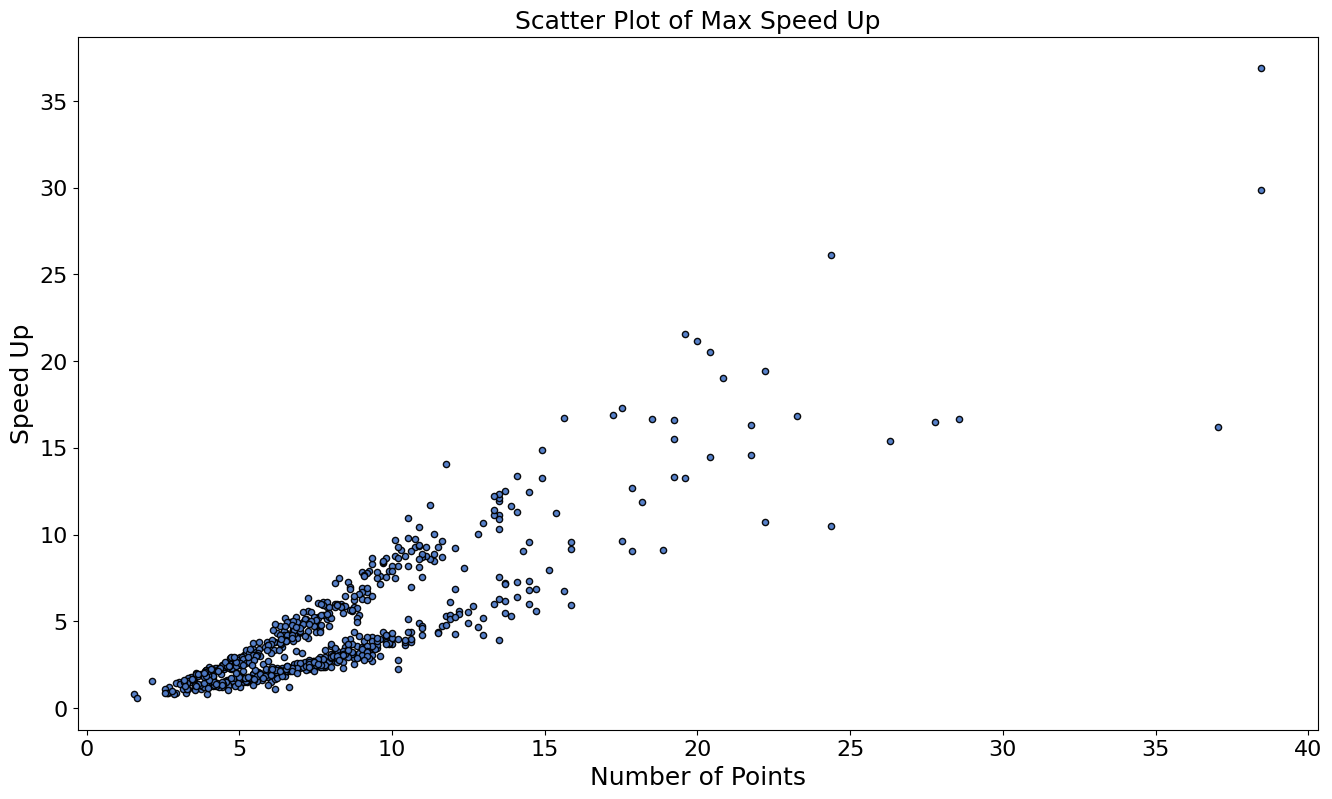

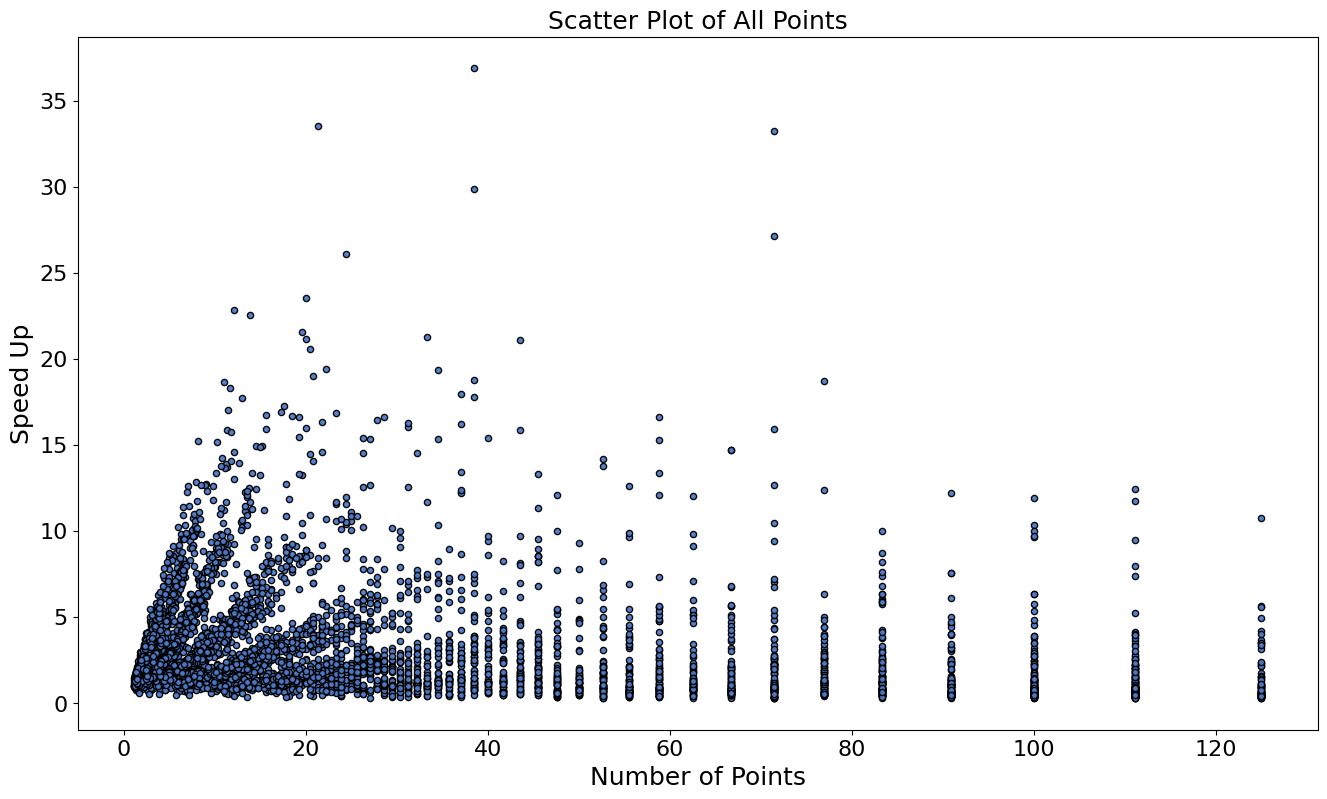

In [14]:
import matplotlib.pyplot as plt

# Второй график
ax = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()].plot(
    figsize=(16, 9), kind='scatter', x='k', y='speed_up', color='#4E7AC7', edgecolor='black', alpha=0.95,  fontsize=16
)
ax.set_xlabel('Number of Points',  fontsize=18)
ax.set_ylabel('Speed Up',  fontsize=18)
ax.set_title('Scatter Plot of Max Speed Up',  fontsize=18)
# Сохранение изображения
# plt.savefig('data/img/scatter_plot_filter.png', dpi=200, bbox_inches='tight')
# Отображение графика
plt.show()

# Третий график
ax = combined_df.plot(
    figsize=(16, 9), kind='scatter', x='k', y='speed_up', color='#4E7AC7', edgecolor='black', alpha=0.95,  fontsize=16
)
ax.set_xlabel('Number of Points',  fontsize=18)
ax.set_ylabel('Speed Up',  fontsize=18)
ax.set_title('Scatter Plot of All Points',  fontsize=18)
# Сохранение изображения
# plt.savefig('data/img/scatter_plot_all.png', dpi=200, bbox_inches='tight')
# Отображение графика
plt.show()